In [2]:
import cv2
import pickle
import numpy as np

import scipy.sparse
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

from mark_out_area import draw_polygon

%matplotlib inline

# 1. Select image

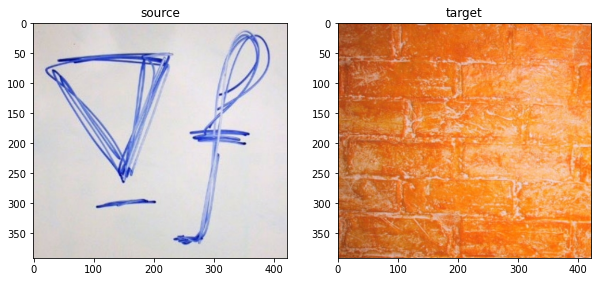

In [7]:
# read src image and convert color space to shades of gray
src_img = cv2.imread("src.jpg")
dst_img = cv2.imread("dst.jpg")

h, w = src_img.shape[:2]
dst_img = cv2.resize(dst_img, (w, h))

plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(src_img[:,:,::-1])
plt.title("source")
plt.subplot(1,2,2)
plt.imshow(dst_img[:,:,::-1])
plt.title("target")
plt.show()

## 1.1. Mark out a region $\Omega$ using a polygon
create polygon, and saved points to 'points.pkl'

[USAGES]: 
 1) LEFT CLICK mouse  -> select point
 2) RIGHT CLICK mouse -> detect last point
 3) press 'p'         -> plot polygon and show, and save points into 'points.pkl' file
 5) press 'ESC'       -> exist


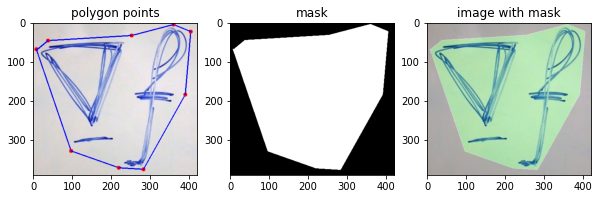

[INFO] polygon points coordinates had been saved in 'points.pkl' ... 


In [13]:
draw_polygon(src_img, "points.pkl")

# 2. Seamless cloning for grayscale images

In [26]:
def laplacian_operator(n, m):
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-4)
    mat_D.setdiag(1, -1)
    mat_D.setdiag(1, 1)
    
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(1, -m)
    mat_A.setdiag(1, m)
    
    return mat_A.tocsc()

def get_gradient(img):
    # 计算x和y方向梯度
    kernel_x = np.array([[0, 0, 0],
                         [0,-1, 1],
                         [0, 0, 0]])
    kernel_y = np.array([[0, 0, 0],
                         [0,-1, 0],
                         [0, 1, 0]])
    grad_x = cv2.filter2D(img, cv2.CV_32F, kernel_x)
    grad_y = cv2.filter2D(img, cv2.CV_32F, kernel_y)
    return grad_x, grad_y

def get_div(v_x):
    # 计算散度
    assert len(v_x) == 2
    grad_x, grad_y = v_x
    kernel_x = np.array([[0, 0, 0],
                         [-1,1, 0],
                         [0, 0, 0]])
    kernel_y = np.array([[0,-1, 0],
                         [0, 1, 0],
                         [0, 0, 0]])
    lap_x = cv2.filter2D(grad_x, cv2.CV_32F, kernel_x)
    lap_y = cv2.filter2D(grad_y, cv2.CV_32F, kernel_y)
    return lap_x + lap_y

## (a) Importing gradients

to implement the Laplacian operator, 
1. first build the matrix $\mathbf{D}$
2. then build matrix $\mathbf{A}$ by setting $\mathbf{D}$ as block diagonal element; suppose that $\mathbf{src, dst} \in \Re^{H \times W}$, then $\mathbf{A} \in \Re^{HW \times HW}$

Now the equation becomes:    
1.  $\mathbf{\Delta f} = \mathbf{\Delta g} \Longleftrightarrow \mathbf{Af} = \mathbf{Ag}$, inside the region 
2. $\mathbf{f} = \mathbf{t}$, outside the region

where<br> 
* $\mathbf{f}$ is the pixel value of seamless cloning image
* $\mathbf{g}$ is the pixel value of the src
* $\mathbf{t}$ is the pixel value of dst

In [27]:
def seamless_clone_one_channel(g, t, mask):
    # g: source image
    # t: target image
    h, w = g.shape[:2]
    
    # generate Laplacian matrix, which is also called laplacian operator or delta operator
    delta = laplacian_operator(h, w)
    A = delta.copy()

    # only apply the Laplacian operator inside the blending region
    # but as for the outside part, set it to identity to dst
    for y in range(1, h-1):
        for x in range(1, w-1):
            if mask[y, x] == 0:
                # for outside part, for setting it to identity, 
                # need to set the "4" to "1", and the rest to "0"
                k = x + y * w
                A[k, k] = 1
                A[k, k-1] = 0
                A[k, k+1] = 0
                A[k, k-w] = 0
                A[k, k+w] = 0
    
    g_flat = g.flatten()
    t_flat = t.flatten()
    mask_flat = mask.flatten()
    
    # for pixel inside the mask, Ag = \Delta g 
    Ag = delta.dot(g_flat)
    
    # for pixel outside the mask, Ag = t_flat
    Ag[mask_flat == 0] = t_flat[mask_flat == 0]
    
    # solve equation Af = Ag, to acquire seamless cloning image f
    x = scipy.sparse.linalg.spsolve(A, Ag)
    x = x.reshape((h, w))
    x = np.clip(x, 0, 255).astype(np.uint8)
    
    return x

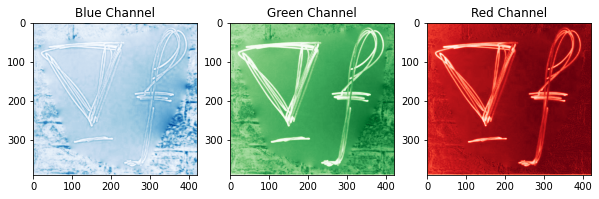

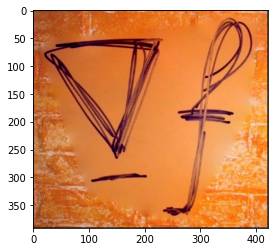

In [28]:
# read src image and convert color space to shades of gray
src_img = cv2.imread("src.jpg")
dst_img = cv2.imread("dst.jpg")

points = np.array(pickle.load(open("points.pkl", "rb")), np.int32).reshape((-1, 1, 2))
mask = np.zeros(src_img.shape[:2], np.uint8)
mask = cv2.fillPoly(mask, [points], (255, 255, 255))

all_channels = []
plt.figure(figsize=(10, 20))
i = 1
for _src, _dst, info, cm in zip(cv2.split(src_img), 
                            cv2.split(dst_img), 
                            ["Blue Channel", "Green Channel", "Red Channel"],
                            [plt.cm.Blues, plt.cm.Greens, plt.cm.Reds]):
    res = seamless_clone_one_channel(_src, _dst, mask)
    all_channels.append(res)
    
    plt.subplot(1, 3, i); i += 1
    plt.imshow(res, cmap=cm)
    plt.title(info)
plt.show()

# merge all channels and show
plt.imshow(cv2.merge(all_channels[::-1]))
plt.show()

## (b) Mixing gradients 
* 计算在mask图像的区域内的融合散度
    1. 在这里不能直接用laplacian算子求出散度然后再进行比较，因为公式里面是要求比较的是梯度，因此需要在梯度上进行融合
    2. 梯度有两个方向： $x$ 方向和 $y$ 方向，每个方向有左、右两个方向的梯度。因此需要对四个方向的梯度进行比较


* 计算源图像、目标图像四个方向的梯度

* 对于每个方向，比较每个像素的源图像梯度和目标图像梯度，取绝对值大的一方作为最终的梯度

* 最后四个方向的梯度累计求和就可以得到最终的散度

* 对于每一个通道，需要构造 $A$ 系数矩阵和 $b$ 向量，然后再利用 $Ax=b$ 求解出该通道的 $x$

In [20]:
def mixed_seamless_clone_per_channel(src, dst, mask):
    h, w = dst.shape[:2]
    
    # 分别计算源图像、目标图像上，x, y方向的梯度
    s_grad_x, s_grad_y = get_gradient(src)
    t_grad_x, t_grad_y = get_gradient(dst)
    
    # 源域梯度向量场
    v_x = (s_grad_x.copy(), s_grad_y.copy())

    for y in range(h):
        for x in range(w):
            if mask[y, x] != 0:
                # 比较每个像素的源图像梯度和目标图像x和y方向的梯度绝对值之和
                # 如果目标域的梯度绝对值之和更大，则将源域的梯度值替换为目标域的梯度值
                if abs(t_grad_x[y, x]) + abs(t_grad_y[y, x]) > abs(s_grad_x[y, x]) + abs(s_grad_y[y, x]):
                    v_x[0][y, x] = t_grad_x[y, x]
                    v_x[1][y, x] = t_grad_y[y, x]
            else:
                v_x[0][y, x] = t_grad_x[y, x]
                v_x[1][y, x] = t_grad_y[y, x]
                
    
    # 计算div(v(x))
    div_v = get_div(v_x)
    div_v[mask == 0] = dst[mask == 0]
    div_v = div_v.flatten()
    
    # 计算\Delta算子，即拉普拉斯矩阵A
    A = laplacian_operator(h, w)
    
    # 修改\Delta算子（矩阵A）中，对应mask为0的部分的像素值值
    for y in range(1, h-1):
        for x in range(1, w-1):
            if mask[y, x] == 0:
                k = x + y * w
                A[k, k] = 1
                A[k, k-1] = 0
                A[k, k+1] = 0
                A[k, k-w] = 0
                A[k, k+w] = 0
    
    # 求解方程div(v) = \Delta f = Af，最终得到f（即为下面的x值）
    f = scipy.sparse.linalg.spsolve(A, div_v)
    f = f.reshape((h, w))
    f = np.clip(f, 0, 255).astype(np.uint8)
    
    return f

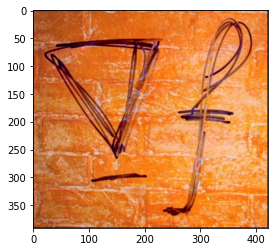

In [22]:
# read src image and convert color space to shades of gray
src_img = cv2.imread("src.jpg")
dst_img = cv2.imread("dst.jpg")

points = np.array(pickle.load(open("points.pkl", "rb")), np.int32).reshape((-1, 1, 2))
mask = np.zeros(src_img.shape[:2], np.uint8)
mask = cv2.fillPoly(mask, [points], (255, 255, 255))

all_channels = []
i = 1
for _src, _dst, info, cm in zip(cv2.split(src_img), 
                            cv2.split(dst_img), 
                            ["Blue Channel", "Green Channel", "Red Channel"],
                            [plt.cm.Blues, plt.cm.Greens, plt.cm.Reds]):
    res = mixed_seamless_clone_per_channel(_src, _dst, mask)
    all_channels.append(res)
    
# merge all channels and show
plt.imshow(cv2.merge(all_channels[::-1]))
plt.show()

# 4. Selection editing effects
Implement only one of the selection editing effects described in Section 4 of the paper (15 points):
* `Texture flattening` 🚀
* Local illumination changes
* Local color changes
* Seamless tiling

In [31]:
def texture_flatten_three_channel(src, mask, alpha = 4):
    h, w = src.shape[:-1]

    s_grad_x, s_grad_y = get_gradient(src)

    for c in range(src.shape[2]):
        for y in range(h):
            for x in range(w):
                if mask[y, x] != 0:
                    if abs(s_grad_x[y, x, c]) < alpha:
                        s_grad_x[y, x, c] = 0
                    if abs(s_grad_y[y, x, c]) < alpha:
                        s_grad_y[y, x, c] = 0

    lap = get_laplacian(s_grad_x, s_grad_y)

    mat_A = laplacian_operator(h, w)

    lap[mask == 0] = src[mask == 0]
    for y in range(1, h-1):
        for x in range(1, w-1):
            if mask[y, x] == 0:
                k = x + y * w
                mat_A[k, k] = 1
                mat_A[k, k-1] = mat_A[k, k+1] = 0
                mat_A[k, k-w] = mat_A[k, k+w] = 0

    res = np.zeros(src.shape)
    mask_flat = mask.flatten()
    for c in range(src.shape[2]):
        mat_b = lap[:,:,c].flatten()

        tmp = scipy.sparse.linalg.spsolve(mat_A, mat_b)
        tmp = tmp.reshape((h, w))
        res[:,:,c] = np.clip(tmp, 0, 255)
    
    return res.astype(np.uint8)

[USAGES]: 
 1) LEFT CLICK mouse  -> select point
 2) RIGHT CLICK mouse -> detect last point
 3) press 'p'         -> plot polygon and show, and save points into 'points.pkl' file
 5) press 'ESC'       -> exist


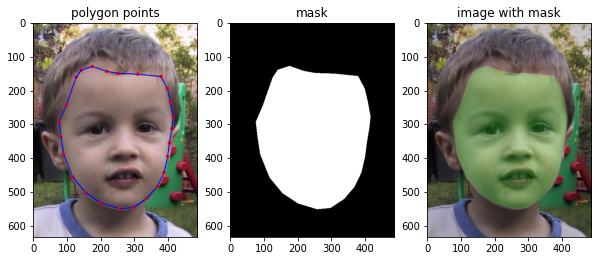

[INFO] polygon points coordinates had been saved in 'points.pkl' ... 


In [27]:
# create mask in 'child.jpg'
src_img = cv2.imread("child.jpg")

draw_polygon(src_img, "points_child.pkl")

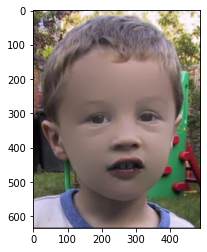

In [33]:
src_img = cv2.imread("child.jpg")

points = np.array(pickle.load(open("points_child.pkl", "rb")), np.int32).reshape((-1, 1, 2))
mask = np.zeros(src_img.shape[:2], np.uint8)
mask = cv2.fillPoly(mask, [points], (255, 255, 255))

res = texture_flatten_three_channel(src_img, mask)

plt.imshow(res[:,:,::-1])
plt.show()

# 5. Opencv Implementation

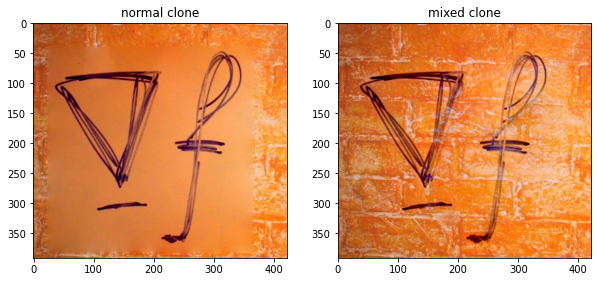

In [73]:
import cv2

src_img = cv2.resize(cv2.imread("src.jpg"), (300, 300))
dst_img = cv2.imread("dst.jpg")

h, w = dst_img.shape[:2]
    
src_mask = 255 * np.ones(src_img.shape, dst_img.dtype)

center = (h//2, w//2)
output1 = cv2.seamlessClone(src_img, dst_img, src_mask, center, cv2.NORMAL_CLONE)
output2 = cv2.seamlessClone(src_img, dst_img, src_mask, center, cv2.MIXED_CLONE)

plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(output1[:,:,::-1])
plt.title("normal clone")
plt.subplot(1,2,2)
plt.imshow(output2[:,:,::-1])
plt.title("mixed clone")
plt.show()